<a href="https://colab.research.google.com/github/FaisalAhmedBijoy/Tensorflow-for-Deep-Learning-Udacity/blob/main/Building_Object_Detection_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [3]:
# Tensorflow and TF Hub
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.4.1
The following GPU devices are available: 


## Display image

In [5]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

## Download and resize image

In [38]:
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  print('Image data: ',image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

Image data:  <_io.BytesIO object at 0x7f373800bf50>
Image downloaded to /tmp/tmp3qzkz4pa.jpg.


'/tmp/tmp3qzkz4pa.jpg'

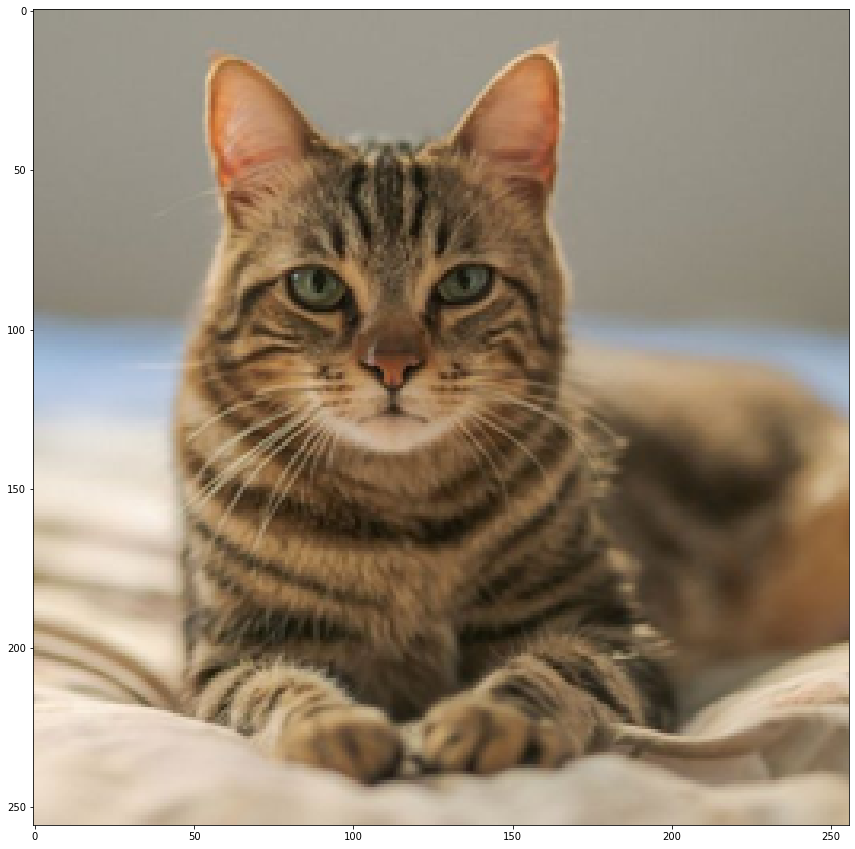

In [7]:
download_and_resize_image('https://i.ibb.co/ZBmd3MK/111434468-gettyimages-1143489763.jpg')

## Drawing bounding Box

In [53]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  print('Left point: ',left)
  print('Right point: ',right)
  print('Top point: ',top)
  print('bottom point:',bottom)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)
  
  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  print('Display str list: ',display_str_list)
  '''
  PIL.ImageFont.ImageFont.getsize(text)
  Returns:	(width, height)
  '''
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  print('Display str heights: ',display_str_heights)
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
  print('Total Display str heights: ',display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


Shape:  (576, 1024, 3)
Data type:  uint8


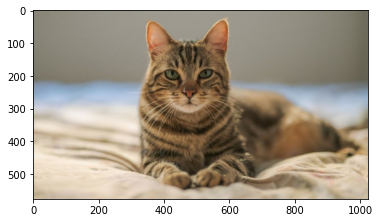

In [13]:
## Testing the Bounding box 
from skimage import io
download_image=io.imread('https://i.ibb.co/ZBmd3MK/111434468-gettyimages-1143489763.jpg')
print('Shape: ',download_image.shape)
print('Data type: ',download_image.dtype)
plt.imshow(download_image)

In [35]:
#draw_bounding_box_on_image(download_image,100,100,400,400,color='red',font=ImageFont.load_default())

## Draw the boxes

In [60]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.8):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

## Apply module

Load a public image from Open Images v4, save locally, and display.

Image data:  <_io.BytesIO object at 0x7f371a9b72f0>
Image downloaded to /tmp/tmpxo2trp57.jpg.


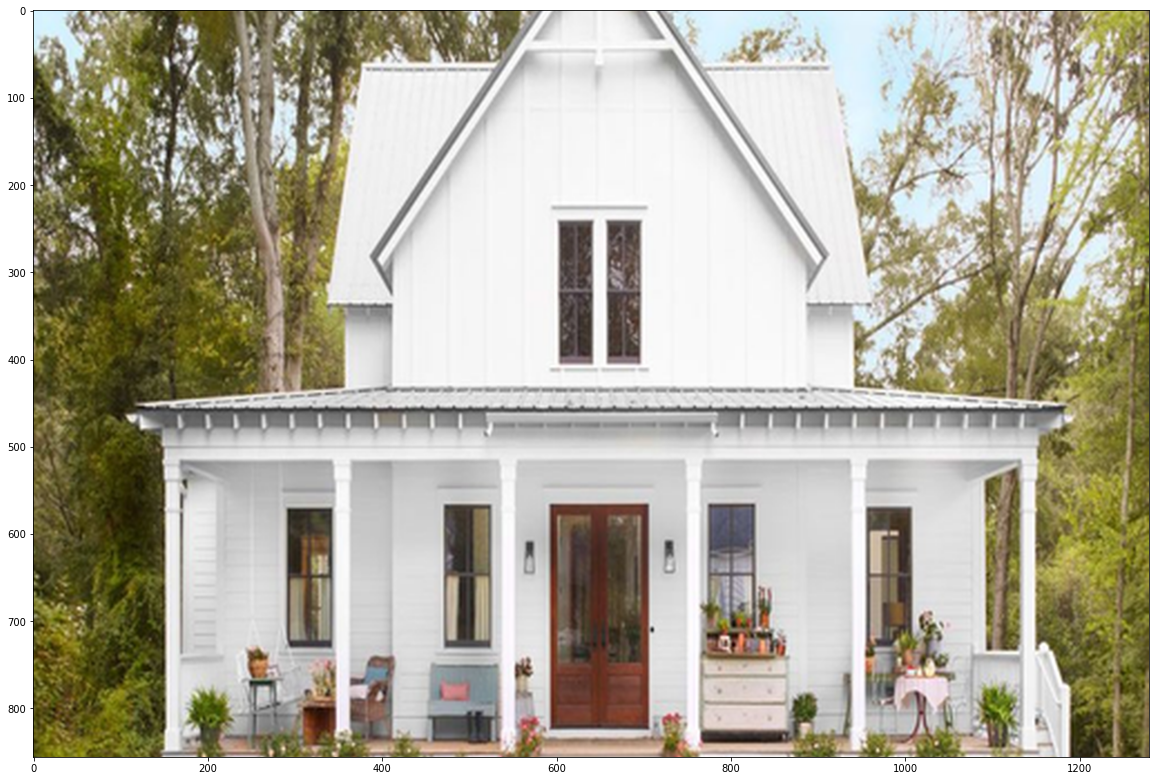

In [64]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "https://i.ibb.co/5BthKCs/building1.png"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Pick an object detection module and apply on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy,
* **ssd+mobilenet V2**: small and fast.

In [41]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Load Image and Run Detector

In [42]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [48]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  print(result.keys())
  print(result)

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

dict_keys(['detection_scores', 'detection_class_labels', 'detection_class_entities', 'detection_class_names', 'detection_boxes'])
{'detection_scores': array([0.9556031 , 0.8098346 , 0.7342955 , 0.70534265, 0.58604217,
       0.44236758, 0.43422842, 0.4143568 , 0.39341706, 0.3577289 ,
       0.28578293, 0.27555913, 0.19970009, 0.18892239, 0.17801954,
       0.17287815, 0.17059393, 0.17051338, 0.16224287, 0.15263034,
       0.13861436, 0.12548298, 0.11666401, 0.11420137, 0.10750829,
       0.10536157, 0.0950487 , 0.09397039, 0.09288447, 0.08906475,
       0.0879236 , 0.08085051, 0.07678644, 0.072749  , 0.06857442,
       0.06372247, 0.05970039, 0.05967721, 0.05925134, 0.05280953,
       0.04797621, 0.04697579, 0.0467294 , 0.04399356, 0.04343433,
       0.0432428 , 0.0424348 , 0.04055853, 0.03809665, 0.03797832,
       0.03539854, 0.02977928, 0.02840493, 0.0271727 , 0.024908  ,
       0.0247288 , 0.02359481, 0.02192393, 0.02165111, 0.02094826,
       0.02089974, 0.02087739, 0.02003113, 0.

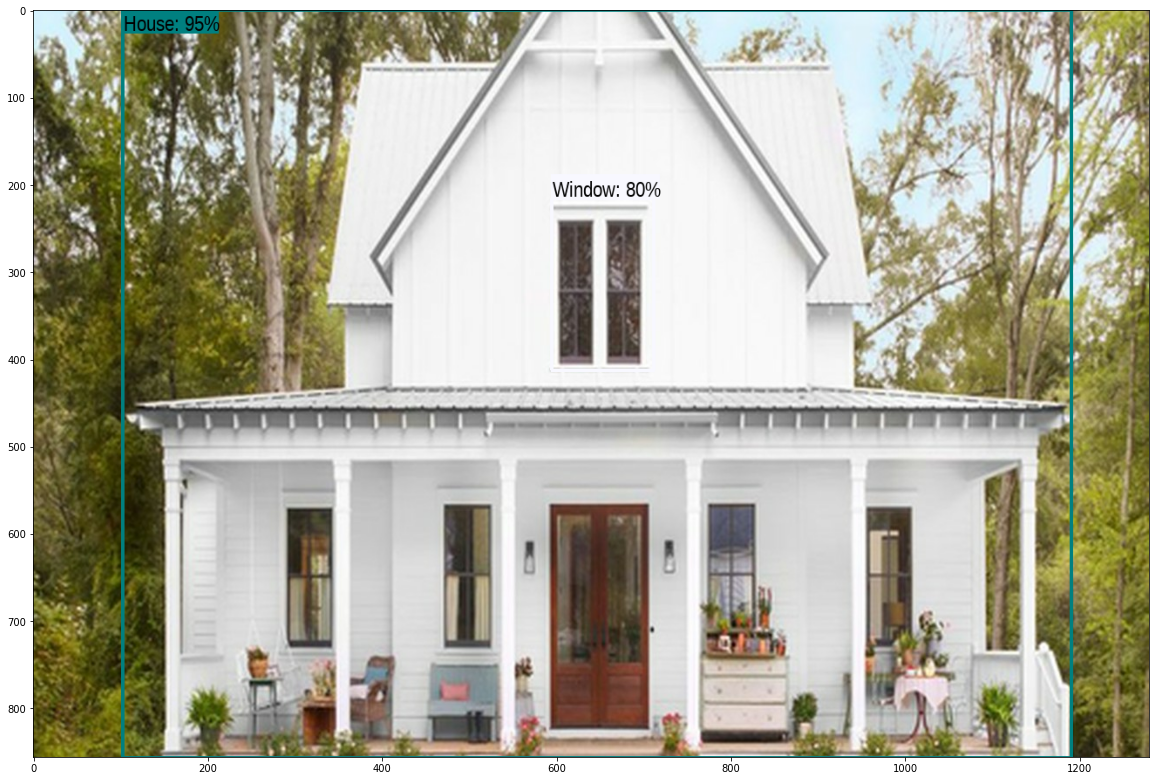

In [65]:
run_detector(detector, downloaded_image_path)